In [594]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import circmean, circstd, circvar
from imaging_behavior_functions import (
    load_intermediate_mat,
    make_df_behavior,
    reconstruct_path,
    load_dff_raw,
    make_df_neural,
    merge_dataframes,
    fit_sinusoid,
    calculate_theta_g_rho
)


### Load old

In [633]:
# other processing

def extract_heatmap(df, roi_kw, roi_kw2):
    if roi_kw2:
        filtered_columns = [col for col in df.columns if roi_kw in col and roi_kw2 not in col]
        roi_mtx = df[filtered_columns]
    else:
        roi_mtx = df[[col for col in df.columns if roi_kw.lower() in col.lower()]]
    if roi_mtx.empty:
        return None
    scaler = StandardScaler()
    roi_mtx = scaler.fit_transform(roi_mtx)
    return roi_mtx

def compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"]):
    """
    For each prefix, computes a new column 'mean_{prefix}'.
    - If both a right and a left column exist (in either format, e.g., '{prefix}R' or '{prefix}_R'),
      their mean is computed.
    - If only one exists, that column's values are used.
    - If neither exists, a message is printed.
    
    Parameters:
        neural_df (pd.DataFrame): DataFrame containing neural measurement columns.
        prefixes (list): List of prefixes for which to compute the mean columns.
        
    Returns:
        pd.DataFrame: The modified DataFrame with new mean columns.
    """
    for prefix in prefixes:
        # Define the possible column names for right and left sides
        possible_right = [f"{prefix}R", f"{prefix}_R"]
        possible_left = [f"{prefix}L", f"{prefix}_L"]
        
        # Check if any of the possible column names exist in the DataFrame
        right_col = next((col for col in possible_right if col in neural_df.columns), None)
        left_col = next((col for col in possible_left if col in neural_df.columns), None)
        mean_col = f"mean_{prefix}"
        
        if right_col and left_col:
            neural_df[mean_col] = (neural_df[right_col] + neural_df[left_col]) / 2
        elif right_col:
            neural_df[mean_col] = neural_df[right_col]
        elif left_col:
            neural_df[mean_col] = neural_df[left_col]
        else:
            print(f"Neither {possible_right} nor {possible_left} found in DataFrame.")
    
    return neural_df


# Example usage:
# neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])

def mean_FB4R(df):
    # Identify columns that contain 'FB4R'
    fb4r_cols = df.columns[df.columns.str.contains('FB4R')]
    # Calculate the row-wise mean for these columns and assign to a new column
    df['mean_FB4R'] = df[fb4r_cols].mean(axis=1)
    return df

def plot_neural_activity_heatmap(df, neural_col, fwV_col, heading_col, modal_heading=None, num_bins_fwV=20, num_bins_heading=20):
    """
    Plots a 2D heatmap of neural activity with an optional red dotted line indicating the modal heading.

    Parameters:
    - df: DataFrame containing the data.
    - neural_col: Column name for neural activity.
    - fwV_col: Column name for forward velocity (fwV).
    - heading_col: Column name for heading.
    - modal_heading: Value of the modal heading to be highlighted (optional).
    - num_bins_fwV: Number of bins for fwV axis (default=20).
    - num_bins_heading: Number of bins for heading axis (default=20).

    Returns:
    - None. Displays the heatmap.
    """
    # Binning the data
    fwV_bins = np.linspace(df[fwV_col].min(), df[fwV_col].max(), num_bins_fwV + 1)
    heading_bins = np.linspace(df[heading_col].min(), df[heading_col].max(), num_bins_heading + 1)

    # Assign bin labels
    df['fwV_bin'] = pd.cut(df[fwV_col], bins=fwV_bins, labels=False, include_lowest=True)
    df['heading_bin'] = pd.cut(df[heading_col], bins=heading_bins, labels=False, include_lowest=True)

    # Group by bins and calculate mean neural activity
    heatmap_data = df.groupby(['fwV_bin', 'heading_bin'])[neural_col].mean().unstack()

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    plt.imshow(heatmap_data, origin='lower', aspect='auto',
               extent=[df[heading_col].min(), df[heading_col].max(),
                       df[fwV_col].min(), df[fwV_col].max()])
    plt.colorbar(label='Average Neural Activity')
    plt.xlabel('Heading')
    plt.ylabel('Forward Velocity (fwV)')

    # Plot the red dotted line for modal heading if provided
    if modal_heading is not None:
        plt.axvline(x=modal_heading, color='red', linestyle='--', linewidth=2, label=f'Modal Heading: {modal_heading}')
        plt.legend()

    # Display the heatmap
    plt.show()


In [634]:




def get_roi_seq_2(roi_df, trial_number):
    roi_df['trialNum'] = roi_df['trialNum'].apply(lambda x: x[0][0])
    
    # Filter the DataFrame to only include rows with the specified trial number
    roi_df = roi_df[roi_df['trialNum'] == trial_number].reset_index(drop=True)
    
    roi_names = roi_df['roiName'].apply(lambda x: x[0])
    roi_hdeltab = roi_names[roi_names.str.contains('hDeltaB', case=False)]
    hdeltab_index = roi_hdeltab.index
    roi_epg = roi_names[roi_names.str.contains('EPG')]
    epg_index = roi_epg.index
    roi_fr1 = roi_names[roi_names.str.contains('FR1') & ~roi_names.str.contains('CRE')]
    fr1_index = roi_fr1.index
    roi_fb4r = roi_names[roi_names.str.contains('FB4R') & ~roi_names.str.contains('CRE')]
    fb4r_index = roi_fb4r.index
    
    hdeltab_seq = roi_hdeltab.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    
    if epg_index.size > 0:
        epg_seq = roi_epg.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        epg_seq = None 
    
    if fr1_index.size > 0:
        fr1_seq = roi_fr1.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fr1_seq = None 
    if fb4r_index.size > 0:
        fb4r_seq = roi_fb4r.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fb4r_seq = None 
    return np.array(roi_names), hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_seq, epg_seq, fr1_seq,fb4r_seq

def sort_rois(dff_tosort, roi_names, query_idx, query_seq):
    sorting_indices = np.argsort(query_seq)
    #print(sorting_indices)
    segment_to_sort = dff_tosort[query_idx]
    #print(segment_to_sort)
    sorted_dff_rois = segment_to_sort[sorting_indices]
    dff_tosort[query_idx] = sorted_dff_rois
    roi_names_sort = roi_names[query_idx]
    roi_names_sort = roi_names_sort[sorting_indices]
    roi_names[query_idx] = roi_names_sort

def make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence,fr1_sequence,fb4r_sequence):
    #TODO
    if hdeltab_index.size > 0:
        #print(1)
        sort_rois(dff_all_rois, roi_names, hdeltab_index, hdeltab_sequence)
    else:
        pass
    if epg_index.size > 0:
        sort_rois(dff_all_rois, roi_names, epg_index, epg_sequence)
    else:
        pass
    if fr1_index.size > 0:
        sort_rois(dff_all_rois, roi_names, fr1_index, fr1_sequence)
    else:
        pass
    if fb4r_index.size > 0:
        sort_rois(dff_all_rois, roi_names, fb4r_index, fb4r_sequence)
    else:
        pass
    # Create a new DataFrame for the reordered data
    neural_df = pd.DataFrame()
    neural_df['time'] = np.squeeze(dff_time)
    #print(len(dff_all_rois))
    # Add each sorted ROI data to the DataFrame with the specified naming convention
    for i, roi_data in enumerate(dff_all_rois):
        column_name =  roi_names[i] # Generate column name starting from hDeltaB1
        neural_df[column_name] = np.squeeze(roi_data)
    # Identify columns where all values are 0
    cols_to_drop = [col for col in neural_df.columns if neural_df[col].eq(0).all()]
    
    # Drop these columns from the DataFrame
    neural_df.drop(columns=cols_to_drop, inplace=True)
    return neural_df

def add_dan_mean_columns(df):
    # Identify columns containing "PAM0708"
    pam0708_cols = [col for col in df.columns if "PAM0708" in col]
    if pam0708_cols:
        df["mean_PAM0708"] = df[pam0708_cols].mean(axis=1)
    else:
        df["mean_PAM0708"] = np.nan  # or handle empty case as desired

    # Identify columns containing "MB441" or "PAM12"
    pam12_cols = [col for col in df.columns if ("MB441" in col) or ("PAM12" in col)]
    if pam12_cols:
        df["mean_PAM12"] = df[pam12_cols].mean(axis=1)
    else:
        df["mean_PAM12"] = np.nan

    return df

In [630]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/old acquisition/"

example_path_data = base_path+"20220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long/data/"
example_path_results = base_path+"20220913-9_MBON09hDeltaB_syntGCAMP7f_fly3_long/results/"
trial_num = 2

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data, trial_num)
behav_df = make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor, trial_num, ball_d=9)
behav_df = reconstruct_path(behav_df, ball_d=9)
# calculate straightness
behav_df = calculate_theta_g_rho(behav_df)

roi_names, hdeltab_index, epg_index, fr1_index, fb4r_index, hdeltab_sequence, epg_sequence, fr1_sequence, fb4r_seq = get_roi_seq_2(roi_df,trial_num)
dff_all_rois, dff_time = load_dff_raw(is_mat73, dff_raw)
neural_df = make_df_neural(
    dff_all_rois,
    dff_time,
    roi_names,
    hdeltab_index,
    epg_index,
    fr1_index,
    fb4r_index,
    hdeltab_sequence,
    epg_sequence,
    fr1_sequence,
    fb4r_seq
)
neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
neural_df = add_dan_mean_columns(neural_df)
#neural_df = add_min_max_normalized_columns(neural_df)
roi_kw = 'hDeltaB'
roi_kw2 = 'MB'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    #print(1)
    roi_mtx = extract_heatmap(neural_df, roi_kw, roi_kw2)
    neural_df,paramfit_df = fit_sinusoid(neural_df,roi_mtx)
merged_df = merge_dataframes(behav_df, neural_df)

Loading with scipy.io failed: Please use HDF reader for matlab v7.3 files, e.g. h5py. Trying with mat73.
Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.


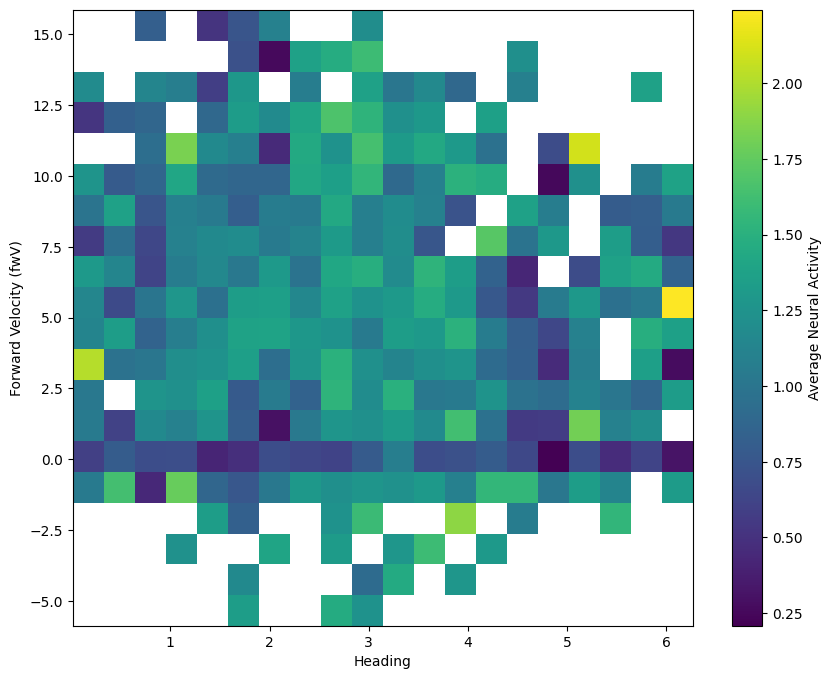

In [557]:
plot_neural_activity_heatmap(merged_df, 'mean_PAM12', 'fwV', 'heading', modal_heading=None, num_bins_fwV=20, num_bins_heading=20)

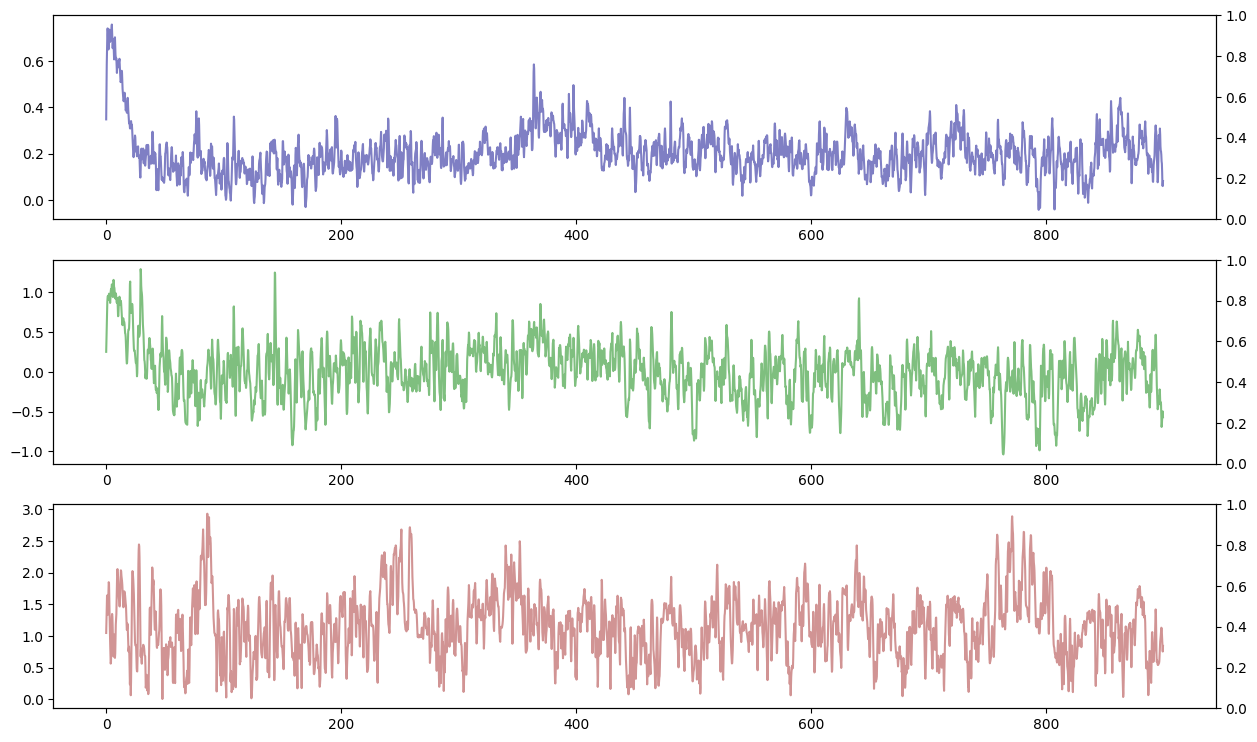

In [632]:
key = 'mean_MBON09'
fig, ax = plt.subplots(3, 1, figsize=(15, 9))
idx1 = 0
idx2 = -1
ax[0].plot(merged_df.time[idx1:idx2], merged_df[key][idx1:idx2],color='darkblue',alpha=0.5)
ax2 = ax[0].twinx()
#ax2.plot(behav_df.time[idx1:idx2], behav_df.fwV[idx1:idx2], color='red',alpha=0.3)
#ax2.plot(merged_df.time[idx1:idx2], merged_df.odor_state[idx1:idx2], color='black',alpha=0.5)

ax[1].plot(merged_df.time[idx1:idx2], merged_df['baseline'][idx1:idx2],color='green',alpha=0.5)
ax3 = ax[1].twinx()
#ax2.plot(behav_df.time[idx1:idx2], behav_df.fwV[idx1:idx2], color='red',alpha=0.3)
#ax3.plot(merged_df.time[idx1:idx2], merged_df.odor_state[idx1:idx2], color='black',alpha=0.5)

ax[2].plot(merged_df.time[idx1:idx2], merged_df['amplitude'][idx1:idx2],color='brown',alpha=0.5)
ax4 = ax[2].twinx()
#ax2.plot(behav_df.time[idx1:idx2], behav_df.fwV[idx1:idx2], color='red',alpha=0.3)
#ax4.plot(merged_df.time[idx1:idx2], merged_df.odor_state[idx1:idx2], color='black',alpha=0.5)
# Add labels and legends
#ax[0].set_xlabel('Time')
#ax[0].set_ylabel(key)
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

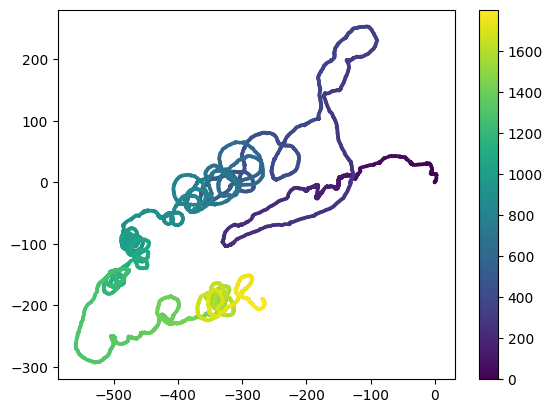

In [598]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

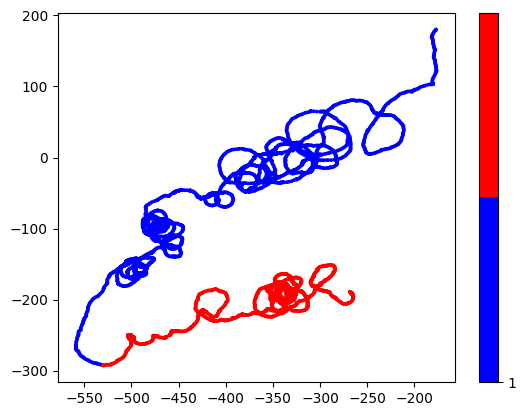

In [614]:

import matplotlib.colors as mcolors

# For demonstration, let's say you decide which rows get which color manually.
# For instance, if you want to assign blue to the first half of the DataFrame and red to the second half:
n = len(behav_df)
# Create a new column 'color_index' with default value 0 (blue)
behav_df['color_index'] = 0  
# Manually set red (index 1) for the second half of the DataFrame
behav_df.loc[behav_df.index >= n/5, 'color_index'] = 1
behav_df.loc[behav_df.index >= 35*n/48, 'color_index'] = 2

# Alternatively, if your DataFrame index is already numeric and you know exactly which indices should be which:
# For example, if you want row with index 0 to be blue and index 1 to be red:
# behav_df.loc[behav_df.index == 1, 'color_index'] = 1

# Create a colormap with two colors: blue for index 0 and red for index 1
cmap = mcolors.ListedColormap(['blue', 'red'])
behav_df_test = behav_df[behav_df.color_index >0]

# Use the manually assigned color indices in your scatter plot
fig = plt.scatter(behav_df_test.xPos, behav_df_test.yPos, s=3, c=behav_df_test['color_index'], cmap=cmap)
plt.colorbar(fig, ticks=[0, 1])
plt.show()


In [27]:
jumpbar_pd = pd.read_csv(example_path_data+'../panel_heading_1.txt',names = ['panel_heading','time','count'])
jumpbar_pd

panel_heading        time  count
0           0.000000    0.020994      1
1           0.000000    0.027992      2
2           0.000080    0.032990      3
3           6.283024    0.037988      4
4           6.282815    0.043989      5
...              ...         ...    ...
30976       4.841745  617.440808  30977
30977       4.854375  617.460801  30978
30978       4.856249  617.481795  30979
30979       4.854501  617.500788  30980
30980       4.853240  617.520782  30981

[30981 rows x 3 columns]

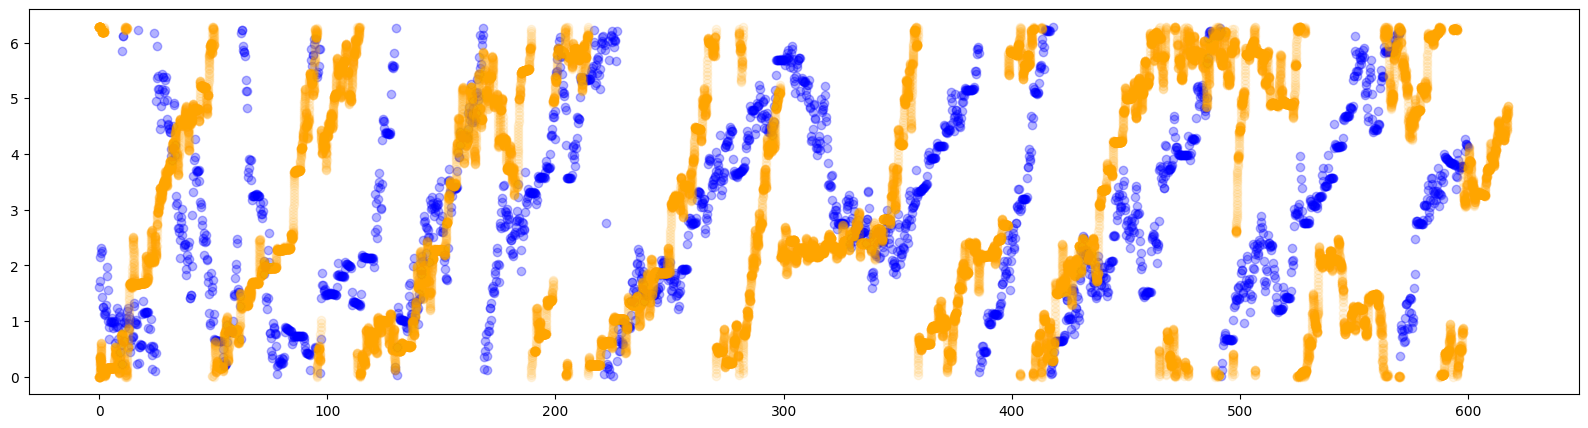

In [31]:
fig_ex, ax = plt.subplots(figsize=[20,5])
x1 = 3000
x2 = 0
ax.scatter(behav_df.time[0:len(behav_df)], 2*np.pi-behav_df.heading[0:len(behav_df)],color ='blue',alpha = 0.3)
ax.scatter(jumpbar_pd.time[:len(jumpbar_pd)-x2], jumpbar_pd.panel_heading[x2:len(jumpbar_pd)],color ='orange',alpha = 0.1)


In [17]:
heading_intp = np.interp(behav_df.time, jumpbar_pd.time[:-x2], 2*np.pi-jumpbar_pd.panel_heading[x2:])
behav_df['heading_jump'] = heading_intp

In [18]:
heading_adj = 2*np.pi-jumpbar_pd.panel_heading[x2:]
jump_label = np.abs(np.diff(np.unwrap(heading_adj)))>2 
jump_idx = np.where(jump_label)

Text(0, 0.5, 'fw velocity (mm/s)')

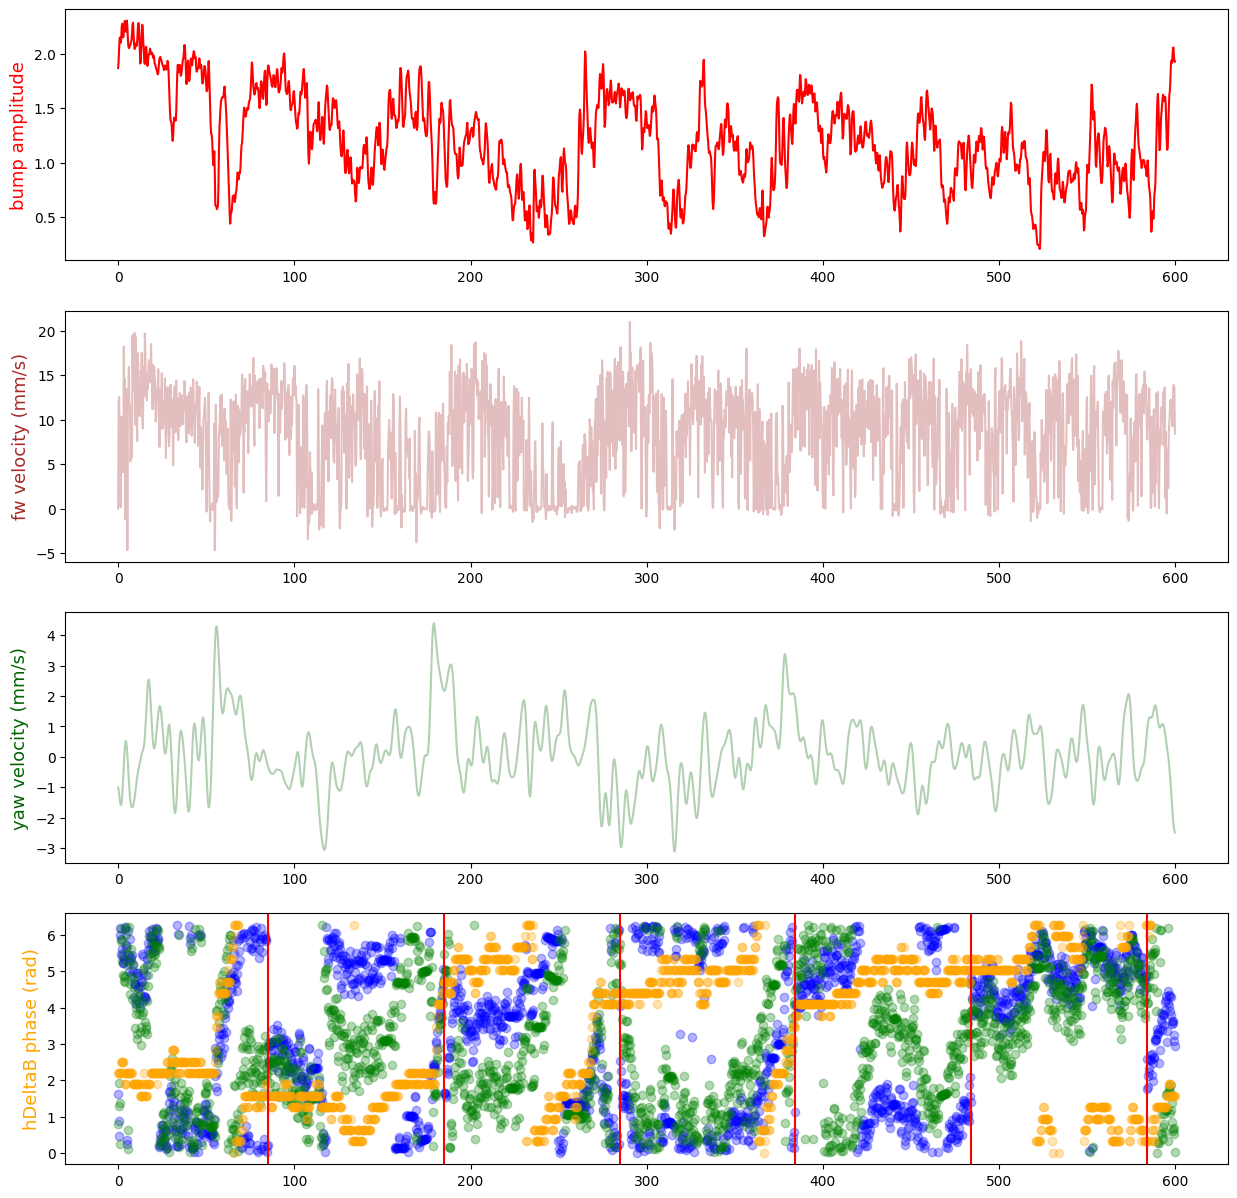

In [20]:
fig_ex, ax = plt.subplots(4,1,figsize=[15,15])
ind1 = 0
ind2 = len(behav_df) 
ax[0].plot(behav_df.time[ind1:ind2], param_df.amplitude[ind1:ind2],color = 'red')
ax[0].set_ylabel('bump amplitude', fontsize = 13, color = 'red')
ax[3].scatter(behav_df.time[ind1:ind2], heading_intp[ind1:ind2],color ='blue',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], behav_df.heading[ind1:ind2],color ='green',alpha = 0.3)
ax[3].scatter(behav_df.time[ind1:ind2], 2*np.pi-param_df.phase[ind1:ind2],color ='orange',alpha = 0.3)
#ax[3].scatter(jumpbar_pd.time[:-600], 2*np.pi-jumpbar_pd.panel_heading[600:],color ='orange',alpha = 0.1)
for i in range(len(jump_idx[0])):
    ax[3].axvline(jumpbar_pd.time[jump_idx[0][i]],color ='red')
ax[3].set_ylabel('hDeltaB phase (rad)', fontsize = 13, color = 'orange')
#ax2 = ax[3].twinx()
ax[2].plot(behav_df.time[ind1:ind2], imaging_behavior_functions.apply_gaussian_smoothing(behav_df.yawV[ind1:ind2],5),color='darkgreen',alpha = 0.3)
ax[2].set_ylabel('yaw velocity (mm/s)', fontsize = 13, color = 'darkgreen')
ax[1].plot(behav_df.time[ind1:ind2],behav_df.fwV[ind1:ind2], color = 'brown',alpha = 0.3)
ax[1].set_ylabel('fw velocity (mm/s)', fontsize = 13, color = 'brown')

In [13]:
# Function to find the index of the closest value
def find_closest_indices(values, highlight_values):
    indices = []
    for value in highlight_values:
        # Compute absolute difference and find the index of the minimum
        index = np.abs(values - value).argmin()
        indices.append(index)
    return indices

In [14]:
highlight_times = np.array(jumpbar_pd.time[jump_idx[0]])
# Find the index of the closest value for each highlight value
highlight_indices = find_closest_indices(behav_df.time, highlight_times)

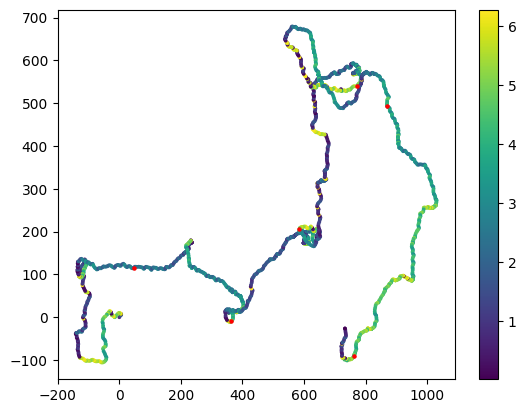

In [15]:
fig = plt.scatter(xPos,yPos,s=3,c = behav_df.heading)
# Highlight specific time points in red
for idx in highlight_indices:
    plt.scatter(xPos[idx], yPos[idx], s=5,color='red')
plt.colorbar(fig)

### Load new and examine bar jump

#### Useful functions

In [635]:
def get_roi_seq_2(roi_df, trial_number):
    roi_df['trialNum'] = roi_df['trialNum'].apply(lambda x: x[0][0])
    
    # Filter the DataFrame to only include rows with the specified trial number
    roi_df = roi_df[roi_df['trialNum'] == trial_number].reset_index(drop=True)
    
    roi_names = roi_df['roiName'].apply(lambda x: x[0])
    roi_hdeltab = roi_names[roi_names.str.contains('hDeltaB', case=False)]
    hdeltab_index = roi_hdeltab.index
    roi_epg = roi_names[roi_names.str.contains('EPG')]
    epg_index = roi_epg.index
    roi_fr1 = roi_names[roi_names.str.contains('FR1') & ~roi_names.str.contains('CRE')]
    fr1_index = roi_fr1.index
    
    hdeltab_seq = roi_hdeltab.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    
    if epg_index.size > 0:
        epg_seq = roi_epg.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        epg_seq = None 
    
    if fr1_index.size > 0:
        fr1_seq = roi_fr1.str.extract(r'_(\d+)')[0].astype(int).to_numpy()
    else:
        fr1_seq = None 
    
    return np.array(roi_names), hdeltab_index, epg_index, fr1_index, hdeltab_seq, epg_seq, fr1_seq

In [636]:
def calculate_pva_hdeltab(activity_matrix, neural_df):
    num_neurons, time_steps = activity_matrix.shape
    directions = np.linspace(0, 2*np.pi, num_neurons, endpoint=False)
    
    # Calculate vector components for each neuron's activity
    x_components = np.cos(directions)[:, np.newaxis] * activity_matrix
    y_components = np.sin(directions)[:, np.newaxis] * activity_matrix
    
    # Sum components across neurons for each time step
    sum_x = np.sum(x_components, axis=0)
    sum_y = np.sum(y_components, axis=0)
    
    # Calculate PVA for each time step
    pva_phase = np.arctan2(sum_y, sum_x)  # Phase in radians
    pva_amplitude = np.sqrt(sum_x**2 + sum_y**2)  # Magnitude of the vector
    
    # Compute baseline: mean activity across neurons for each time step
    baseline = np.mean(activity_matrix, axis=0)
    
    # Save computed values into neural_df
    neural_df['phase'] = pva_phase
    neural_df['amplitude'] = pva_amplitude
    neural_df['baseline'] = baseline
    
    return neural_df

def compute_prestimulus_metrics(df, state_col="odor_state", time_col="time",
                                fwv_col="fwV", heading_col="heading", rho_t_col="rho_t",
                                pre_window=5):
    """
    Computes prestimulus locomotion metrics at off-to-on transitions.
    
    For each off-to-on transition (i.e., when the state changes from 0 to 1), the following metrics are computed:
      - Prestimulus average forward velocity (fwV) over the time window preceding the transition.
      - Prestimulus circular average of heading.
      - Prestimulus circular variance of heading (assuming heading is in the range [0, π]).
      - Prestimulus average rho_t (straightness measure).
      - Average fwV during the entire on period (from transition onset to next off transition).
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing locomotion data.
    - state_col (str): Name of the binary state column (0 = off, 1 = on).
    - time_col (str): Name of the time column.
    - fwv_col (str): Column name for forward velocity.
    - heading_col (str): Column name for heading (in radians, assumed to be in [0, π]).
    - rho_t_col (str): Column name for straightness measure.
    - pre_window (float): Duration (in the same units as time_col) of the prestimulus window.
    
    Returns:
    - pd.DataFrame with the following additional columns:
        - 'prestim_avg_fwv': Prestimulus average forward velocity.
        - 'prestim_circavg_heading': Prestimulus circular average of heading.
        - 'prestim_circvar_heading': Prestimulus circular variance of heading.
        - 'prestim_avg_rho_t': Prestimulus average straightness.
        - 'on_avg_fwv': Average forward velocity during the on period.
    """


    # Identify off-to-on transitions: where the previous state is 0 and the current state is 1.
    onset_indices = df.index[(df[state_col].shift(1, fill_value=0) == 0) & (df[state_col] == 1)]
    # Identify on-to-off transitions for computing on period metrics.
    offset_indices = df.index[(df[state_col].shift(1, fill_value=1) == 1) & (df[state_col] == 0)]

    # Initialize new metric columns with NaN.
    df["prestim_avg_fwv"] = np.nan
    df["prestim_circavg_heading"] = np.nan
    df["prestim_circvar_heading"] = np.nan
    df["prestim_avg_rho_t"] = np.nan
    df["on_avg_fwv"] = np.nan

    for event_idx in onset_indices:
        event_time = df.loc[event_idx, time_col]

        # Define prestimulus window: from (event_time - pre_window) to event_time.
        window_start_time = event_time - pre_window
        prestim_window = df[(df[time_col] >= window_start_time) & (df[time_col] < event_time)]

        if not prestim_window.empty:
            # Calculate prestimulus metrics.
            df.loc[event_idx, "prestim_avg_fwv"] = prestim_window[fwv_col].mean()
            df.loc[event_idx, "prestim_avg_rho_t"] = prestim_window[rho_t_col].mean()
            # Compute circular statistics for heading.
            df.loc[event_idx, "prestim_circavg_heading"] = circmean(prestim_window[heading_col])
            df.loc[event_idx, "prestim_circvar_heading"] = circvar(prestim_window[heading_col])

        # Define the on period: from the event time to the next off event.
        next_offsets = offset_indices[offset_indices > event_idx]
        if not next_offsets.empty:
            next_off_idx = next_offsets.min()
            on_window = df[(df[time_col] >= event_time) & (df[time_col] < df.loc[next_off_idx, time_col])]
        else:
            # If no subsequent off event exists, take all data from event_time to end.
            on_window = df[df[time_col] >= event_time]

        if not on_window.empty:
            df.loc[event_idx, "on_avg_fwv"] = on_window[fwv_col].mean()

    return df



In [637]:
def plot_aligned_traces(
    df, binary_col, query_col, time_col, color_col=None, align_to="on", window=(-1, 1), bins=None, is_circular=False
):
    """
    Plots query variable traces aligned to binary state ON or OFF transitions.
    If `is_circular` is True, uses a scatter plot.
    """
    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Store all extracted traces
    all_traces = []
    time_shifts = []
    colors = []

    # Iterate over transitions
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]  # Get transition time
        start_time, end_time = t0 + window[0], t0 + window[1]  # Define window range
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]  # Extract data

        if not subset.empty:
            aligned_time = subset[time_col] - t0  # Align time to transition (t=0)
            all_traces.append(subset[query_col].values)  # Store query variable values
            time_shifts.append(aligned_time.values)  # Store aligned time values
            colors.append(df.loc[idx, color_col] if color_col else None)  # Store color variable

    # Convert to arrays
    all_traces = np.array(all_traces, dtype=object)
    time_shifts = np.array(time_shifts, dtype=object)

    # Default to blue if no color column is provided
    if color_col is None:
        colors = None
    else:
        colors = np.array(colors)

    # Handle binning of the color variable
    if color_col and bins is not None:
        bin_edges = np.linspace(colors.min(), colors.max(), bins + 1)
        color_bins = np.digitize(colors, bin_edges) - 1  # Bin indices
        unique_bins = np.unique(color_bins)
    else:
        color_bins = colors if colors is not None else None
        unique_bins = np.unique(colors) if colors is not None else None

    # Define colormap
    cmap = cm.get_cmap("viridis", len(unique_bins)) if color_col else cm.get_cmap("viridis")
    norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max()) if color_col else None

    plt.figure(figsize=(8, 5))

    # Choose plot type based on is_circular
    for i, (time_trace, query_trace) in enumerate(zip(time_shifts, all_traces)):
        if color_col:
            bin_idx = color_bins[i] if bins is not None else colors[i]
            color = cmap(norm(bin_idx))
        else:
            color = cmap(i / len(all_traces))

        if is_circular:
            plt.scatter(time_trace, query_trace, s=15, color=color, alpha=0.5)
        else:
            plt.plot(time_trace, query_trace, alpha=0.3, color=color)

    # Labels and legend
    plt.xlabel("Time (s, aligned to transition)")
    plt.ylabel(query_col)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)  # Mark transition point
    plt.title(f"{query_col} aligned to {binary_col} {align_to.upper()} transitions")
    
    if color_col:
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=color_col)
    
    plt.grid(True)
    plt.show()


def plot_aligned_traces_2(
    df, binary_col, query_col, time_col, color_col=None, align_to="on", window=(-1, 1), bins=None, is_circular=False
):
    """
    Plots query variable traces aligned to binary state ON or OFF transitions.
    For each trace, the mean over the prestimulus window (t < 0) is subtracted
    so that the baseline is aligned across events.
    If `is_circular` is True, the baseline is computed using circular statistics
    (assuming values are in the range 0 to 2pi) and the subtraction is performed modulo 2pi.
    """
    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Store all extracted traces
    all_traces = []
    time_shifts = []
    colors = []

    # Iterate over transitions
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]  # Get transition time
        start_time, end_time = t0 + window[0], t0 + window[1]  # Define window range
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]  # Extract data

        if not subset.empty:
            # Align time to transition (t=0)
            aligned_time = subset[time_col].values - t0
            query_trace = subset[query_col].values

            # Identify the prestimulus period (t < 0)
            baseline_mask = aligned_time < 0
            if baseline_mask.any():
                baseline_values = query_trace[baseline_mask]
            else:
                baseline_values = query_trace

            # Compute baseline and subtract it from the trace
            if is_circular:
                # Circular mean: compute mean of exp(i*theta) then extract angle
                baseline = np.angle(np.mean(np.exp(1j * baseline_values)))
                # Ensure baseline is in [0, 2pi]
                if baseline < 0:
                    baseline += 2 * np.pi
                # Subtract baseline modulo 2pi
                query_trace = (query_trace - baseline) % (2 * np.pi)
            else:
                baseline = np.mean(baseline_values)
                query_trace = query_trace - baseline

            # Append adjusted trace and corresponding aligned time
            all_traces.append(query_trace)
            time_shifts.append(aligned_time)
            colors.append(df.loc[idx, color_col] if color_col else None)

    # Convert to arrays
    all_traces = np.array(all_traces, dtype=object)
    time_shifts = np.array(time_shifts, dtype=object)

    # Default to blue if no color column is provided
    if color_col is None:
        colors = None
    else:
        colors = np.array(colors)

    # Handle binning of the color variable
    if color_col and bins is not None:
        bin_edges = np.linspace(colors.min(), colors.max(), bins + 1)
        color_bins = np.digitize(colors, bin_edges) - 1  # Bin indices
        unique_bins = np.unique(color_bins)
    else:
        color_bins = colors if colors is not None else None
        unique_bins = np.unique(colors) if colors is not None else None

    # Define colormap
    cmap = cm.get_cmap("rainbow", len(unique_bins)) if color_col else cm.get_cmap("rainbow")
    norm = mcolors.Normalize(vmin=colors.min(), vmax=colors.max()) if color_col else None

    plt.figure(figsize=(8, 5))

    # Plot each trace
    for i, (time_trace, query_trace) in enumerate(zip(time_shifts, all_traces)):
        if color_col:
            bin_idx = color_bins[i] if bins is not None else colors[i]
            color = cmap(norm(bin_idx))
        else:
            color = cmap(i / len(all_traces))

        if is_circular:
            plt.scatter(time_trace, query_trace, s=15, color=color, alpha=0.7)
        else:
            plt.plot(time_trace, query_trace, alpha=0.7, color=color)

    # Labels and legend
    plt.xlabel("Time (s, aligned to transition)")
    plt.ylabel(query_col)
    plt.axvline(0, color="k", linestyle="--", linewidth=1)  # Mark transition point
    plt.title(f"{query_col} aligned to {binary_col} {align_to.upper()} transitions")
    
    if color_col:
        plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), label=color_col)
    
    plt.grid(True)
    plt.show()

def plot_aligned_traces_twinx(
    df, 
    binary_col, 
    query_cols,  # expects exactly two columns: e.g. ['MBON09', 'heading']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # can be a boolean or list/tuple of booleans [for left, for right]
    do_baselincorr=True
):
    """
    Plots two query variable traces aligned to binary state transitions.
    The first variable (query_cols[0]) is plotted on the left y-axis,
    while the second variable (query_cols[1]) is plotted on a twin y-axis.
    For each variable, if it is circular (e.g. angles in radians) it is plotted as a scatter plot.
    
    Parameters:
      - df: DataFrame containing the time series.
      - binary_col: Column name used to detect transitions (e.g., landmark jumps).
      - query_cols: List of exactly two column names (e.g., ['MBON09', 'heading']).
      - time_col: Column name with time values.
      - align_to: Either "on" or "off" indicating which transitions to align.
      - window: Tuple (start, end) relative to the transition time.
      - is_circular: Boolean or list/tuple of booleans. If True for a variable, baseline correction 
                     uses circular statistics and the variable is plotted as scatter.
      - do_baselincorr: If True, subtracts the pre-event (t < 0) baseline from each trace.
    """

    # Allow is_circular to be specified per variable
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular, is_circular]
    elif len(is_circular) != 2:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of two booleans.")

    # Detect transitions (state changes)
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")
    
    num_events = len(transition_idxs)
    if num_events == 0:
        print("No transitions detected.")
        return
    
    # Create a grid of subplots: one per jump event
    ncols = int(np.ceil(np.sqrt(num_events)))
    nrows = int(np.ceil(num_events / ncols))
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*5, nrows*4), squeeze=False)

    # Set default colors for the two variables
    color_left = 'b'
    color_right = 'r'
    
    # Iterate over each event
    for i, idx in enumerate(transition_idxs):
        ax = axs[i // ncols, i % ncols]
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        
        # Align time to the event (t=0)
        aligned_time = subset[time_col].values - t0

        # Calculate average forward velocity (fwV) in the prestimulus window (t < 0)
        if 'fwV' in subset.columns:
            prestim_mask = aligned_time < 0
            if prestim_mask.any():
                avg_fwV = np.mean(np.abs(subset.loc[prestim_mask, 'fwV'].values))
            else:
                avg_fwV = np.nan
        else:
            avg_fwV = np.nan


        # Process first variable (left y-axis)
        trace_left = subset[query_cols[0]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_left[baseline_mask] if baseline_mask.any() else trace_left
            if is_circular[0]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_left = (trace_left - baseline) % (2 * np.pi)
            else:
                baseline = np.mean(baseline_vals)
                trace_left = trace_left - baseline

        # Plot left variable using scatter if circular, otherwise a line
        if is_circular[0]:
            ax.scatter(aligned_time, trace_left, color=color_left, label=query_cols[0], s=5,alpha=0.5)
        else:
            ax.plot(aligned_time, trace_left, color=color_left, label=query_cols[0], alpha=0.5)
        
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel(query_cols[0], color=color_left)
        ax.set_ylim(0, 2*np.pi) if is_circular[0] else [-0.15,0.3]
        ax.tick_params(axis='y', labelcolor=color_left)
        ax.axvline(0, color="k", linestyle="--", linewidth=1)
        ax.grid(True)

        # Process second variable (right y-axis)
        trace_right = subset[query_cols[1]].values.copy()
        if do_baselincorr:
            baseline_mask = aligned_time < 0
            baseline_vals = trace_right[baseline_mask] if baseline_mask.any() else trace_right
            if is_circular[1]:
                baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                if baseline < 0:
                    baseline += 2 * np.pi
                trace_right = (trace_right - baseline + np.pi) % (2 * np.pi) 
            else:
                baseline = np.mean(baseline_vals)
                trace_right = trace_right - baseline

        # Create twin axis for second variable and plot accordingly
        ax2 = ax.twinx()
        if is_circular[1]:
            ax2.scatter(aligned_time, trace_right, color=color_right, label=query_cols[1], s=5,alpha=0.5)
        else:
            ax2.plot(aligned_time, trace_right, color=color_right, label=query_cols[1], alpha=0.5)
        ax2.set_ylabel(query_cols[1], color=color_right)
        ax2.set_ylim(0, 2*np.pi) if is_circular[1] else [-0.15,0.3]
        ax2.tick_params(axis='y', labelcolor=color_right)

        #ax.set_title(f"Jump event at t={t0:.2f}")

        # Combine legends from both axes
        lines_left, labels_left = ax.get_legend_handles_labels()
        lines_right, labels_right = ax2.get_legend_handles_labels()
        ax.legend(lines_left + lines_right, labels_left + labels_right, loc="upper left")
        ax.set_title(f"Jump at t={t0:.2f}\nAvg net_motion_state (pre-stim): {avg_fwV:.2f}")
    
    # Remove any unused subplots
    total_subplots = nrows * ncols
    for k in range(i+1, total_subplots):
        fig.delaxes(axs[k // ncols, k % ncols])
    
    fig.suptitle("Aligned Traces with Dual Axes for Each Jump Event", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


def plot_heatmap_aligned_traces(
    df, 
    binary_col, 
    query_cols,  # e.g., ['mean_MBON09', 'phase']
    time_col, 
    align_to="on", 
    window=(-1, 1), 
    is_circular=False,  # either a single bool (applied to all) or a list of booleans per variable
    do_baselincorr=True
):
    """
    Creates heatmaps of aligned traces for each jump event.
    
    Each row of the heatmap corresponds to one jump event, and the columns represent
    time (relative to the jump). Two heatmaps are produced (one per variable in query_cols):
      - For non-circular variables (e.g. mean_MBON09), a sequential colormap is used.
      - For circular variables (e.g. phase, with values between 0 and 2π), a circular colormap is used.
    
    Baseline correction (zeroing out the pre-jump mean) is applied if do_baselincorr is True.
    
    Parameters:
      - df: DataFrame with the time series.
      - binary_col: Column used to detect jump transitions.
      - query_cols: List of two column names to visualize (e.g. ['mean_MBON09', 'phase']).
      - time_col: Column name with time values.
      - align_to: 'on' or 'off', indicating which transition to align.
      - window: Tuple (start, end) specifying the window relative to the jump.
      - is_circular: Boolean or list of booleans (one per query variable) indicating if the variable is circular.
      - do_baselincorr: If True, subtract the pre-event (t < 0) baseline from each event.
    """
    import matplotlib.colors as mcolors

    # Allow is_circular to be specified per variable
    nvars = len(query_cols)
    if not isinstance(is_circular, (list, tuple)):
        is_circular = [is_circular] * nvars
    elif len(is_circular) != nvars:
        raise ValueError("is_circular must be either a single boolean or a list/tuple of booleans with the same length as query_cols")

    # Detect transitions based on binary column changes
    if align_to == "on":
        transition_idxs = df.index[(df[binary_col] == 1) & (df[binary_col].shift(1) == 0)]
    elif align_to == "off":
        transition_idxs = df.index[(df[binary_col] == 0) & (df[binary_col].shift(1) == 1)]
    else:
        raise ValueError("align_to must be 'on' or 'off'.")

    # Dictionary to store traces for each query variable for every event.
    traces_dict = {col: [] for col in query_cols}
    time_axis = None  # we assume all events yield the same aligned time vector

    # Loop over detected events and extract traces within the specified window.
    for idx in transition_idxs:
        t0 = df.loc[idx, time_col]
        start_time = t0 + window[0]
        end_time = t0 + window[1]
        subset = df[(df[time_col] >= start_time) & (df[time_col] <= end_time)]
        if subset.empty:
            continue
        # Align time so that t=0 corresponds to the jump.
        aligned_time = subset[time_col].values - t0
        # Save the time axis from the first event.
        if time_axis is None:
            time_axis = aligned_time
        else:
            # If the event has a different number of points, skip it.
            if len(aligned_time) != len(time_axis):
                continue
        
        # Process each query variable.
        for i, col in enumerate(query_cols):
            trace = subset[col].values.copy()
            if do_baselincorr:
                baseline_mask = aligned_time < 0
                baseline_vals = trace[baseline_mask] if baseline_mask.any() else trace
                if is_circular[i]:
                    # Compute circular mean and subtract modulo 2π.
                    baseline = np.angle(np.mean(np.exp(1j * baseline_vals)))
                    if baseline < 0:
                        baseline += 2 * np.pi
                    trace = (trace - baseline) % (2 * np.pi)
                else:
                    baseline = np.mean(baseline_vals)
                    trace = trace - baseline
            traces_dict[col].append(trace)
    
    # Convert collected traces into 2D arrays: rows = events, columns = time points.
    heatmap_data = {}
    for col in query_cols:
        if len(traces_dict[col]) > 0:
            heatmap_data[col] = np.vstack(traces_dict[col])
        else:
            heatmap_data[col] = None

    # Create subplots: one heatmap per query variable.
    n_plots = len(query_cols)
    fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 6), squeeze=False)
    
    for i, col in enumerate(query_cols):
        ax = axes[0, i]
        data = heatmap_data[col]
        if data is None:
            continue
        # For circular variables use a circular colormap (e.g., hsv) with limits 0 to 2π.
        if is_circular[i]:
            cmap = plt.get_cmap("hsv")
            norm = mcolors.Normalize(vmin=0, vmax=2 * np.pi)
        else:
            cmap = plt.get_cmap("viridis")
            norm = None
        
        # Plot the heatmap using imshow. Here the x-axis covers the time window,
        # and the y-axis indexes the jump events.
        im = ax.imshow(
            data,
            aspect="auto",
            origin="lower",
            extent=[time_axis[0], time_axis[-1], 1, data.shape[0]],
            cmap=cmap,
            norm=norm
        )
        ax.axvline(0, color='k', linestyle='--', linewidth=3)
        ax.set_xlabel("Time (s, aligned to jump)")
        ax.set_ylabel("Jump Event #")
        ax.set_title(f"Heatmap of {col}")
        fig.colorbar(im, ax=ax, label=col)
    
    fig.suptitle("Aligned Heatmaps for Jump Events", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


#### Individual trial examination

In [671]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_FB4R_hDeltaB/new acquisition/"
folder_name = "20250302-4_MBON09hDeltaB_nobar"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
bar_jump = False
is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = get_roi_seq_2(roi_df, trial_num)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions.extract_heatmap_2(neural_df, roi_kw, roi_kw2)
    #neural_df,paramfit_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
    neural_df = calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=95)
#behav_df = imaging_behavior_functions.detect_jumps_unwrapped(behav_df, 'heading', 'time', jump_threshold=np.pi/4, min_time_between_jumps=60)
behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_5_v2(behav_df,50,time_lengths=[300,120,300],detection_threshold=0.05,required_consecutive=5)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)

#behav_df = imaging_behavior_functions.calc_segment_modes_filtered_v2(behav_df)
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df)

#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)
# Get both filtered data and mask
'''motion_threshold=1
behav_df, motion_mask = filter_by_motion(behav_df, 
                                                motion_threshold, 
                                                return_mask=True)'''
# Apply same mask to neural_df if needed
#neural_df = neural_df[motion_mask]
merged_df = imaging_behavior_functions.merge_dataframes(neural_df, behav_df)


Neither ['MBON21R', 'MBON21_R'] nor ['MBON21L', 'MBON21_L'] found in DataFrame.
Loaded using mat73.


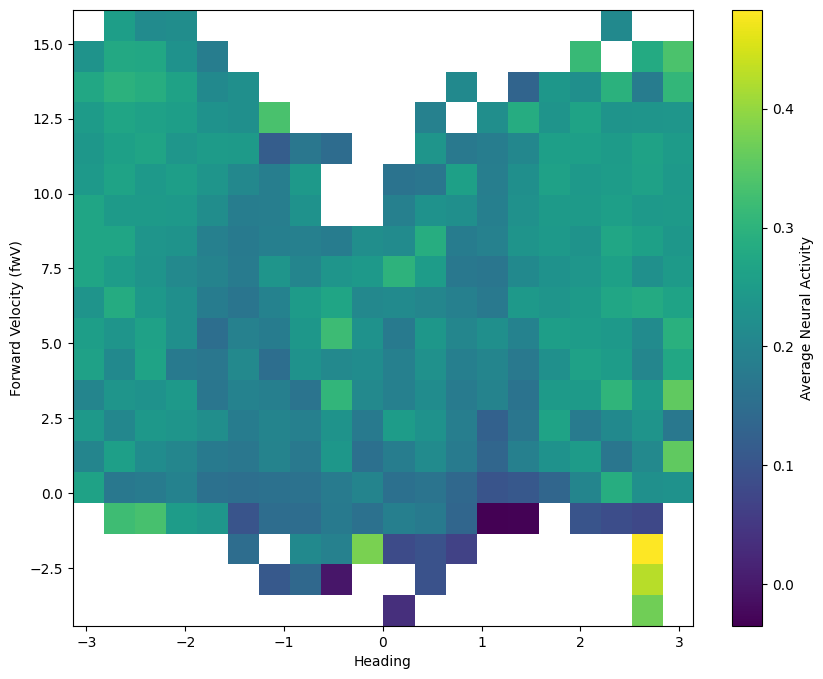

In [672]:
plot_neural_activity_heatmap(merged_df, 'mean_MBON09', 'fwV', 'phase', modal_heading=None, num_bins_fwV=20, num_bins_heading=20)

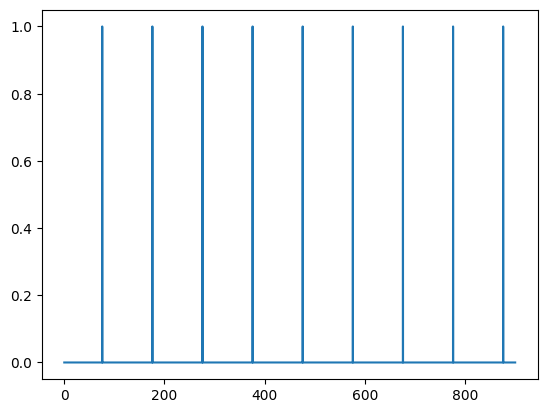

In [578]:
plt.plot(merged_df.time,merged_df.jump_detected)

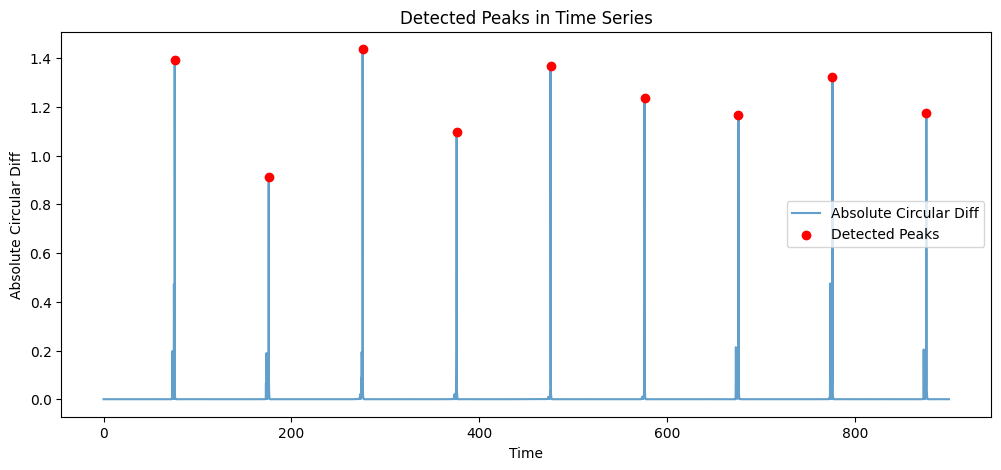

In [579]:
# Plot the data
plt.figure(figsize=(12, 5))
plt.plot(behav_df["time"], behav_df["absolute_circular_diff"], label="Absolute Circular Diff", alpha=0.7)
plt.scatter(behav_df[behav_df["jump_detected"] == 1]["time"], 
            behav_df[behav_df["jump_detected"] == 1]["absolute_circular_diff"], 
            color='red', label="Detected Peaks", zorder=3)
plt.xlabel("Time")
plt.ylabel("Absolute Circular Diff")
plt.legend()
plt.title("Detected Peaks in Time Series")
plt.show()




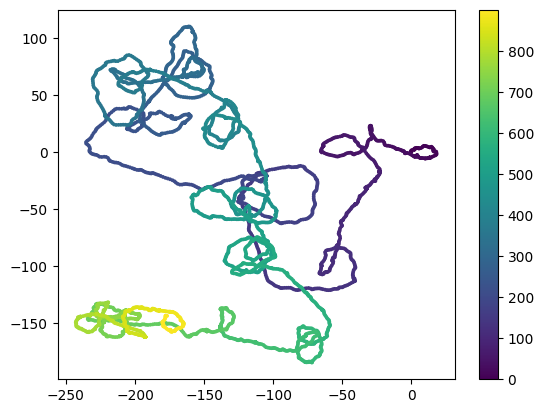

In [651]:
fig = plt.scatter(behav_df.xPos,behav_df.yPos,s=3,c = behav_df.time)
plt.colorbar(fig)

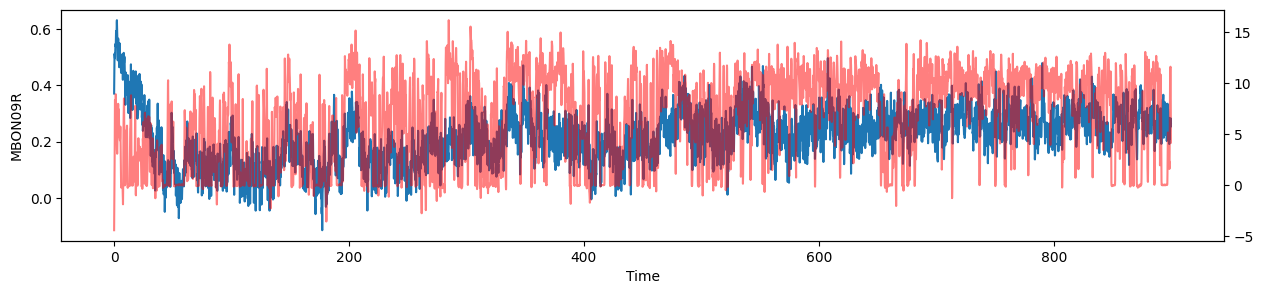

In [675]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df['mean_MBON09'][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.fwV[idx1:idx2], color='red',alpha=0.5)
# Extracting indices where jump_detected is 1
#jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
#ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('MBON09R')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

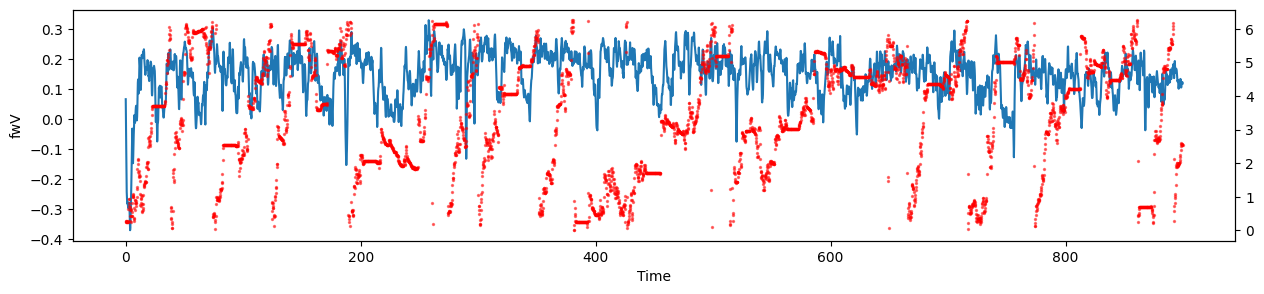

In [669]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df['mean_MBON21'][idx1:idx2])
ax2 = ax.twinx()
ax2.scatter(merged_df.time[idx1:idx2], merged_df.heading[idx1:idx2], color='red',s = 2, alpha=0.5)
# Extracting indices where jump_detected is 1
#jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
#ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('fwV')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

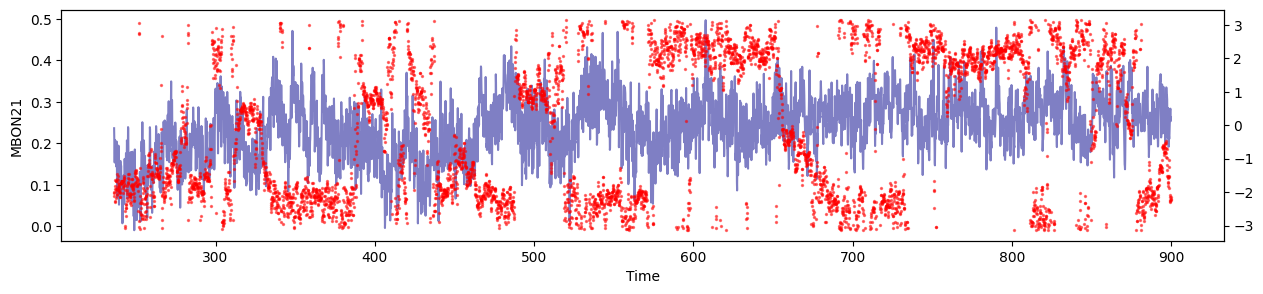

In [679]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 2000
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df['mean_MBON09'][idx1:idx2],color = 'darkblue',alpha =0.5)
ax2 = ax.twinx()
ax2.scatter(neural_df.time[idx1:idx2], neural_df.phase[idx1:idx2], color='red',s = 2, alpha=0.5)
# Extracting indices where jump_detected is 1
#jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
#ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('MBON21')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

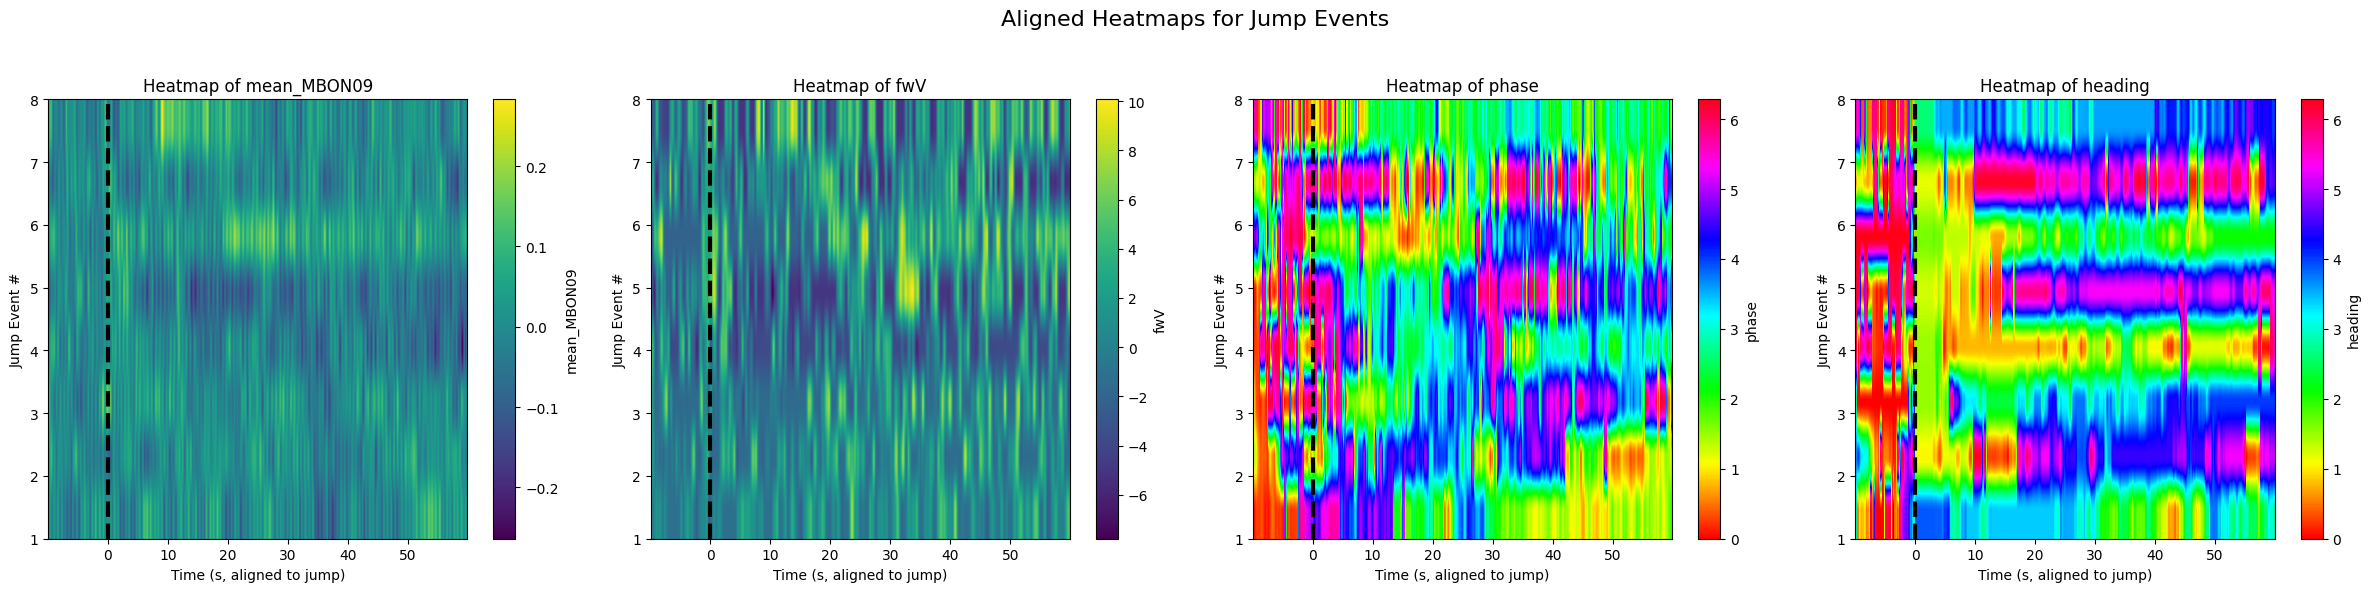

In [574]:
plot_heatmap_aligned_traces(
   merged_df, 'jump_detected', ['mean_MBON09','fwV','phase','heading'], 'time',align_to="on", window=(-10, 60), is_circular=[False,False,True,True], do_baselincorr=True
)

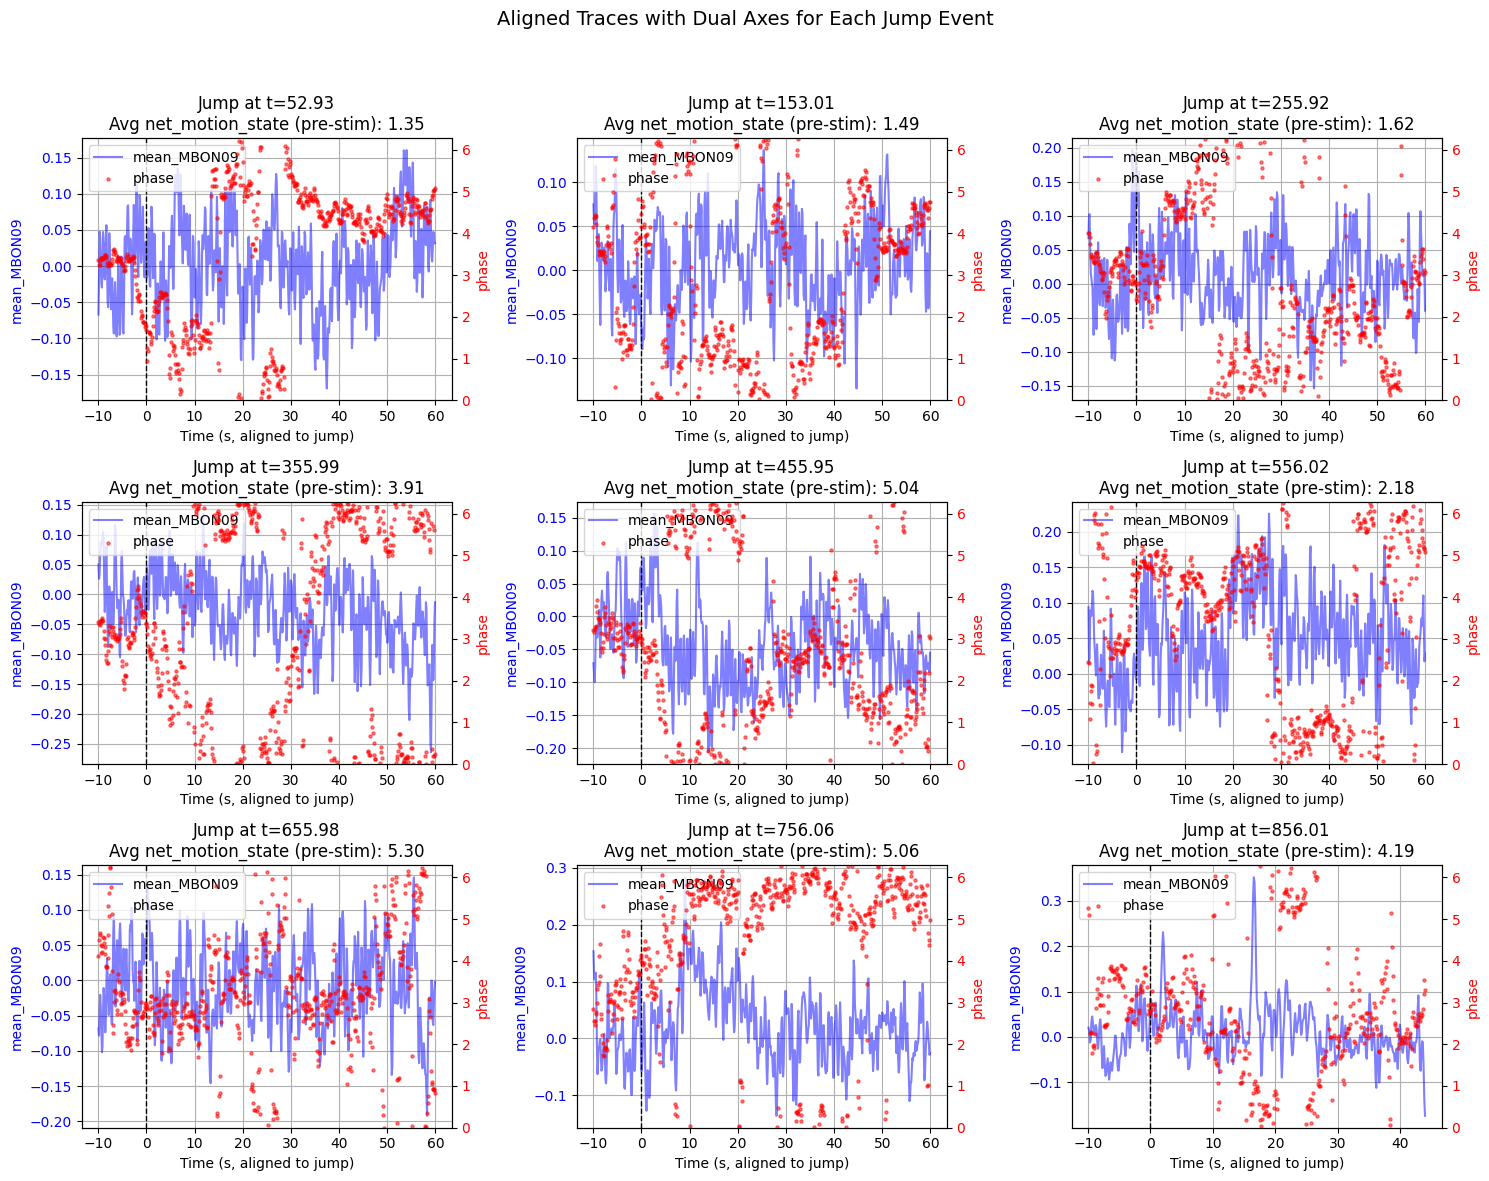

In [573]:
plot_aligned_traces_twinx(
    merged_df, 'jump_detected', ['mean_MBON09','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

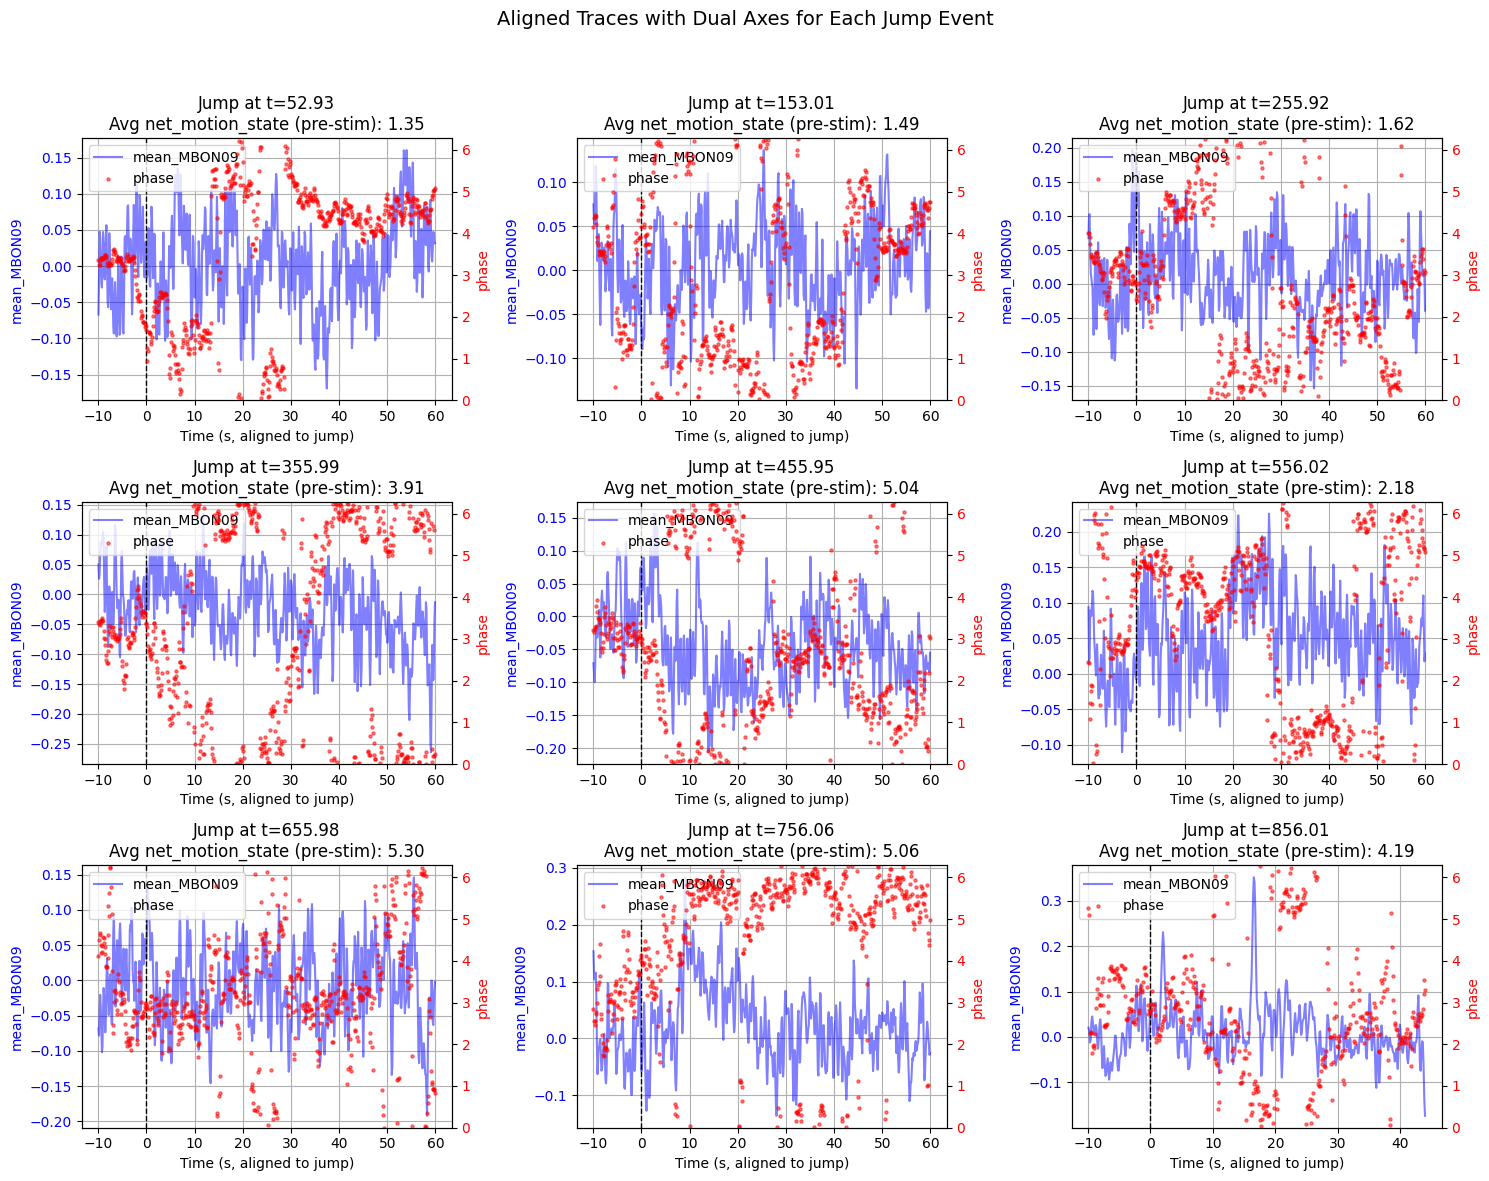

In [267]:
plot_aligned_traces_twinx(
    merged_df, 'jump_detected', ['mean_MBON09','phase'], 'time',align_to="on", window=(-10, 60), is_circular=[False,True], do_baselincorr=True
)

### Load new and examine visual open loop


In [213]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/standby/"
folder_name = "20250302-3_MBON09hDeltaB_visualopenloop"
example_path_data = base_path+f"{folder_name}/data/"
example_path_results = base_path+f"{folder_name}/results/"
trial_num = 1
bar_jump = False
visual_openloop = True
is_mat73, roi_df, dff_raw = imaging_behavior_functions.load_intermediate_mat_new(example_path_data,trial_num)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = get_roi_seq_2(roi_df, trial_num)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
neural_df = compute_mean_neural_columns(neural_df, prefixes=["MBON09", "MBON21"])
roi_kw = 'hDeltaB'
roi_kw2 = 'CRE'
if len([col for col in neural_df.columns if roi_kw.lower() in col.lower()])>0:
    roi_mtx = imaging_behavior_functions.extract_heatmap_2(neural_df, roi_kw, roi_kw2)
    #neural_df,paramfit_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
    neural_df = calculate_pva_hdeltab(roi_mtx.T, neural_df)
    
behav_df, neural_df_new = imaging_behavior_functions.load_matfile_to_df(example_path_data, folder_name, trial_num,is_odor_trial=True)
behav_df = imaging_behavior_functions.rename_dataframe(behav_df)
behav_df = calculate_theta_g_rho(behav_df)
if bar_jump:
    behav_df = imaging_behavior_functions.compute_absolute_circular_diff(behav_df)
    behav_df = imaging_behavior_functions.detect_local_peaks(behav_df, init_t=0, prominence=0.1, min_time_gap=95)
if visual_openloop:
    behav_df['heading_state'] = behav_df['heading']>1.5
    behav_df['heading_state'] = behav_df['heading_state'].astype(int)
    behav_df = compute_prestimulus_metrics(behav_df, state_col="heading_state", time_col="time",
                                fwv_col="fwV", heading_col="heading", rho_t_col="rho_t",
                                pre_window=5)
#behav_df = imaging_behavior_functions.detect_jumps_unwrapped(behav_df, 'heading', 'time', jump_threshold=np.pi/4, min_time_between_jumps=60)
behav_df = imaging_behavior_functions.make_df_behavior_new(behav_df)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_5_v2(behav_df,50,time_lengths=[300,120,300],detection_threshold=0.05,required_consecutive=5)
#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)

#behav_df = imaging_behavior_functions.calc_segment_modes_filtered_v2(behav_df)
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df)

#behav_df, block_boundaries = imaging_behavior_functions.label_blocks_3(behav_df,50)
# Get both filtered data and mask
'''motion_threshold=1
behav_df, motion_mask = filter_by_motion(behav_df, 
                                                motion_threshold, 
                                                return_mask=True)'''
# Apply same mask to neural_df if needed
#neural_df = neural_df[motion_mask]
merged_df = imaging_behavior_functions.merge_dataframes(neural_df, behav_df,method = 'nearest')


Neither MBON21R nor MBON21L found in DataFrame.
Loaded using mat73.


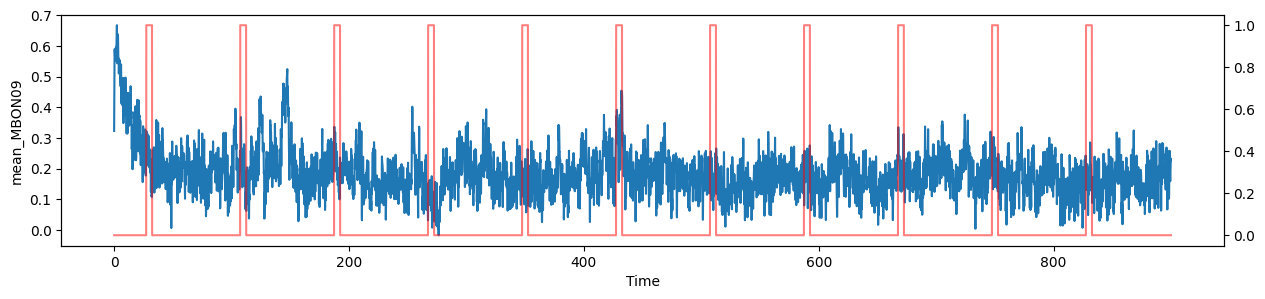

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df['mean_MBON09'][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.heading_state[idx1:idx2], color='red', alpha=0.5)
# Extracting indices where jump_detected is 1
#jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
#ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('mean_MBON09')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

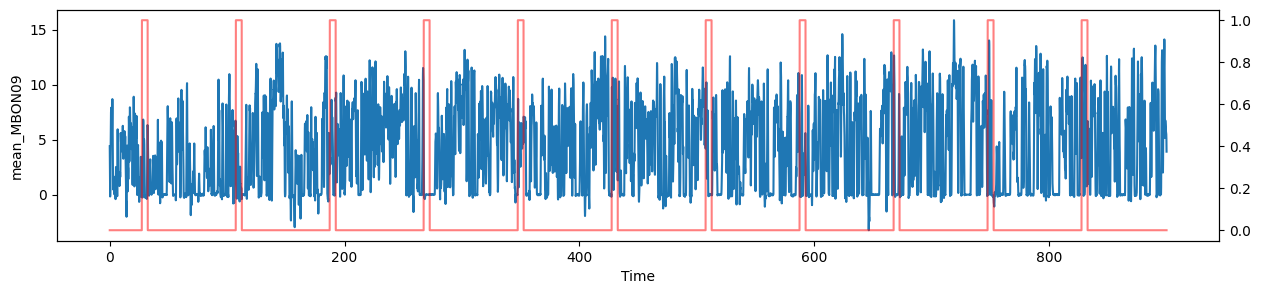

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))
idx1 = 0
idx2 = -1
ax.plot(merged_df.time[idx1:idx2], merged_df['fwV'][idx1:idx2])
ax2 = ax.twinx()
ax2.plot(merged_df.time[idx1:idx2], merged_df.heading_state[idx1:idx2], color='red', alpha=0.5)
# Extracting indices where jump_detected is 1
#jump_indices = behav_df[behav_df['jump_detected'] == 1].index

# Plotting all vertical lines in a single call
#ax2.vlines(behav_df.time[jump_indices], ymin=0, ymax=6, colors='black', linestyles='--', label='Jump Detected')

# Add labels and legends
ax.set_xlabel('Time')
ax.set_ylabel('mean_MBON09')
#ax.set_xlim(behav_df.time[idx1], behav_df.time[idx2])
#ax.legend()

plt.show()

try jump np.pi

In [227]:
def plot_neural_activity(df, pre_window_size, post_window_size, plot_columns=["MBON09L", "MBON09R", "MBON21L", "MBON21R"], sigma=None, plot_kw='past_interval', is_onset=True, bounds=[10, 25, 100, 200],percentile_range=[0, 100]):
    for column in plot_columns:
        if column not in df.columns:
            raise ValueError(f"Column {column} not found in the dataframe.")

    if "time" not in df.columns:
        raise ValueError("Column 'time' not found in the dataframe.")

    if sigma:
        for column in plot_columns:
            if column != "heading":
                smoothed_column_name = f"{column}_smoothed"
                df[smoothed_column_name] = gaussian_filter1d(df[column], sigma)

    heading_onsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 0) & (df["heading_state"] == 1)]
    heading_offsets = df.index[(df["heading_state"].shift(1, fill_value=0) == 1) & (df["heading_state"] == 0)]

    fig, axs = plt.subplots(len(plot_columns) // 2, 2, figsize=(12, 2 * len(plot_columns)))
    axs = axs.ravel()

    for i, column in enumerate(plot_columns):
        aligned_traces = []
        trace_colors = []
        
        column = f"{column}_smoothed" if sigma else column

        for j in range(len(heading_onsets) - 1):
            onset = heading_onsets[j]
            offset = heading_offsets[j]
            
            if is_onset:
                start = max(0, onset - pre_window_size)
                end = min(len(df), onset + post_window_size)
                time_ref = onset
            else:
                start = max(0, offset - pre_window_size)
                end = min(len(df), offset + post_window_size)
                time_ref = offset
            
            trace = df[column].iloc[start:end].reset_index(drop=True)
            time_trace = df["time"].iloc[start:end] - df["time"].iloc[time_ref]

            if np.array(time_trace)[-1] > 0 and np.array(time_trace)[0] < 0:
                aligned_traces.append((time_trace.reset_index(drop=True), trace))
                if is_onset:
                    value = df.loc[onset, plot_kw]
                else:
                    value = df.loc[offset, plot_kw]
                if value is not None:
                    trace_colors.append(value)
        
        if trace_colors:
            lower_bound, upper_bound = np.percentile(trace_colors, percentile_range)
            norm = plt.Normalize(max(min(trace_colors), lower_bound), min(max(trace_colors), upper_bound))
            cmap = plt.cm.rainbow
        
        for idx, (time_trace, trace) in enumerate(aligned_traces):
            color = cmap(norm(trace_colors[idx])) if trace_colors else "blue"
            axs[i].plot(time_trace, trace, alpha=0.4, color=color)

        if bounds:
            grouped_traces = {str(idx): [] for idx in range(len(bounds) + 1)}
            
            for idx, value in enumerate(trace_colors):
                if value < bounds[0]:
                    grouped_traces["0"].append(aligned_traces[idx][1])
                else:
                    for b_idx in range(1, len(bounds)):
                        if bounds[b_idx - 1] <= value < bounds[b_idx]:
                            grouped_traces[str(b_idx)].append(aligned_traces[idx][1])
                            break
                    else:
                        grouped_traces[str(len(bounds))].append(aligned_traces[idx][1])
            
            for group, traces in grouped_traces.items():
                if traces:
                    mean_trace = pd.DataFrame(traces).mean()
                    mean_time = pd.Series([-pre_window_size + i for i in range(pre_window_size + post_window_size)])
                    
                    group_values = [trace_colors[idx] for idx, value in enumerate(trace_colors)
                                    if (value < bounds[0] and group == "0") or
                                    any(bounds[b_idx - 1] <= value < bounds[b_idx] and group == str(b_idx) for b_idx in range(1, len(bounds))) or
                                    (value >= bounds[-1] and group == str(len(bounds)))]
                    
                    if group_values:
                        group_avg = np.mean(group_values)
                        color = cmap(norm(group_avg))
                        axs[i].plot(time_trace, mean_trace, color=color, label=f"{group} (avg: {group_avg:.2f})")
     
        
        axs[i].axvline(x=0, color='red', linestyle='--', label='Heading Onset')
        
        if trace_colors:
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axs[i])
            cbar.set_label(f"{plot_kw.capitalize()} Value")
        
        axs[i].set_title(f"Neural Activity: {column}")
        axs[i].set_xlabel(f"Time (seconds, aligned to heading {'onset' if is_onset else 'offset'})")
        axs[i].set_ylabel("Activity")
    
    plt.tight_layout()
    plt.show()


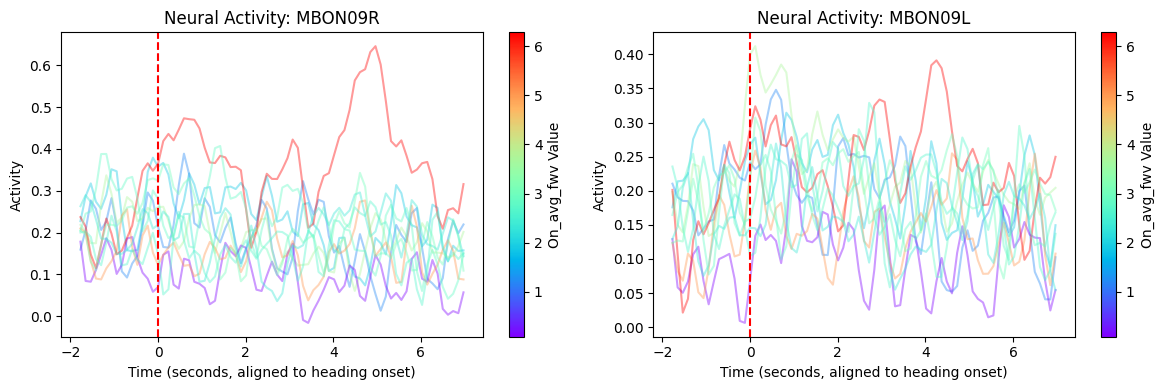

In [230]:
plot_neural_activity(merged_df, 15, 60, plot_columns=["MBON09R","MBON09L"], sigma=None, plot_kw='on_avg_fwv', is_onset=True, bounds=None,percentile_range=[0, 100])

